In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader
from wilds.common.grouper import CombinatorialGrouper
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from tqdm import tqdm
from irm_helpers import *
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import sys
import os
import time
from Classifier import Classifier
from SubsampledDataset import SubsampledDataset
import math

device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
BATCH_SIZE = 64
torch.cuda.empty_cache()

<font size="6">Load train and validation data</font>

In [ ]:
dataset = get_dataset(dataset="fmow", download=False)
grouper = CombinatorialGrouper(dataset, ["region"])

train_data = dataset.get_subset(
    "train",
    transform=transforms.Compose(
        [transforms.ToTensor()]
    ),
)

ood_val_data = dataset.get_subset(
    "val",
    transform=transforms.Compose(
        [transforms.ToTensor()]
    ),
)

id_val_data = dataset.get_subset(
    "id_val",
    transform=transforms.Compose(
        [transforms.ToTensor()]
    ),
)

# train_dataset = SubsampledDataset(train_data, grouper)
# ood_val_dataset = SubsampledDataset(ood_val_data, grouper)
# id_val_dataset = SubsampledDataset(id_val_data, grouper)

train_dataset = torch.load("subsampled_data/train.pt")
ood_val_dataset = torch.load("subsampled_data/ood_val.pt")
id_val_dataset = torch.load("subsampled_data/id_val.pt")


train_loader = get_train_loader("standard", train_dataset, batch_size=BATCH_SIZE)
ood_val_loader   = get_train_loader("standard", ood_val_dataset, batch_size=BATCH_SIZE)
id_val_loader    = get_train_loader("standard", id_val_dataset, batch_size=BATCH_SIZE)


In [ ]:
# torch.save(train_dataset, "subsampled_data/train.pt")
# torch.save(ood_val_dataset, "subsampled_data/ood_val.pt")
# torch.save(id_val_dataset, "subsampled_data/id_val.pt")
# train_dataset = torch.load("subsampled_data/train.pt")
# train_loader = get_train_loader("standard", train_dataset, batch_size=BATCH_SIZE)

# for x, y, metadata in train_loader:
# 	print(x.shape)
# 	break
# print(len(id_val_loader))

In [ ]:
NUM_CLASSES = 10
model = Classifier(NUM_CLASSES)
model.to(device)

<font size="6">Train and accumulate evaluation per epoch</font>

In [ ]:
NUM_EPOCHS = 30
LEARNING_RATE = 0.0001
MODEL_PATH = "models"
MOMENTUM = 0.9


model_name = f"IRM_{NUM_CLASSES}_{NUM_EPOCHS}_SGD_{LEARNING_RATE}_{MOMENTUM}_CrossEntropy.pth"
save_name = os.path.join(MODEL_PATH, model_name)

loss_fn = nn.CrossEntropyLoss(reduction="none")
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

train_evolution = []
val_evolution = []
id_val_evolution = []
best_loss = sys.float_info.max

for epoch in range(NUM_EPOCHS):
	print(f"EPOCH {epoch + 1}:")
	# train
	y_true, y_pred, metadata, loss = train_step(model, train_loader, loss_fn, optimizer, device)
	train_evolution.append(build_metrics_dict(dataset, y_true, y_pred, metadata, loss))
	print(f"Train Loss: {loss}")

	# validation
	y_true, y_pred, metadata, loss = val_step(model, ood_val_loader, loss_fn, device)
	val_evolution.append(build_metrics_dict(dataset, y_true, y_pred, metadata, loss))
	print(f"OOD Loss: {loss}")

	# save by best ood loss
	if loss < best_loss:
		best_loss = loss
		torch.save(model, save_name)

	# in distribution validation
	y_true, y_pred, metadata, loss = val_step(model, id_val_loader, loss_fn, device)
	id_val_evolution.append(build_metrics_dict(dataset, y_true, y_pred, metadata, loss))
	print(f"ID Loss: {loss}")



<font size="6">Plot loss and accuracy per region</font>

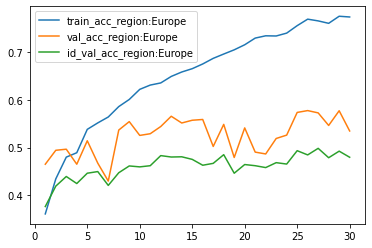

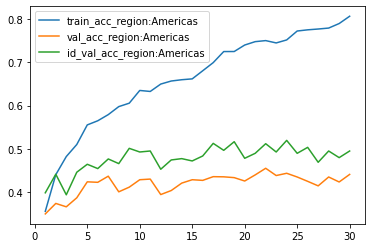

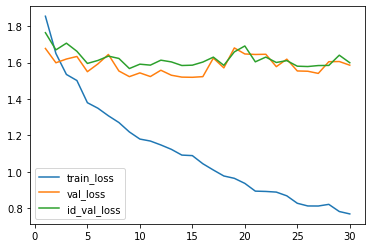

In [8]:
metrics = list(train_evolution[0].keys())

for metric in metrics:
	plot_graph(metric, train_evolution, val_evolution, id_val_evolution, NUM_EPOCHS)